# 准备

In [1]:
from __future__ import print_function, division
import jupyterthemes.jtplot as jtplot
jtplot.style()
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, scale
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, Input, Embedding, SimpleRNN, GRU, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Flatten, Activation
from keras.optimizers import Adadelta, Adam, RMSprop

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 微软雅黑字体
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import tushare as ts

Using TensorFlow backend.


In [2]:
# 获取数据
df = ts.get_hist_data('601857', start='2017-06-15', end='2019-11-06')
data = df

# 尝试1

In [35]:
# 数据预处理
dd = df[['open', 'high', 'low', 'close']]
dd1 = dd.sort_index()  # 逆序排列
dd2 = dd1.values.flatten()
# 将上面排序之后的数据，从最后一个向最前一个，全部放在一维数组里面
#这步操作实际对交易流水的行为就是：从交易开始日期到交易结束日期的数据，
#根据选择的特征，例如：开盘价，最高价，最低价，收盘价；四个一节段，平接在一起，存放在一个一维数组里面.
g1 = dd2[::-1]  # 继续将上面的数组进行逆序，获取的结果将是从收盘当日往前推若干个日期的交易数据
dd3 = pd.DataFrame(dd1['close'])

In [13]:
def load_data(df, sequence_length=10, split=0.8):

    #df = pd.read_csv(file_name, sep=',', usecols=[1])
    #data_all = np.array(df).astype(float)

    data_all = np.array(df).astype(float)
    scaler = MinMaxScaler()
    data_all = scaler.fit_transform(data_all)
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i:i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')
    #np.random.shuffle(reshaped_data)
    # 对x进行统一归一化，而y则不归一化
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1]
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[:split_boundary]
    test_x = x[split_boundary:]

    train_y = y[:split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler


def build_model():
    # input_dim是输入的train_x的最后一个维度，train_x的维度为(n_samples, time_steps, input_dim)
    model = Sequential()
    #model.add(LSTM(input_dim=1, units=6, return_sequences=True))
    #model.add(LSTM(6, input_dim=1, return_sequences=True))
    model.add(LSTM(units=8, input_shape=(None, 1), return_sequences=True))
    """
    #model.add(LSTM(input_dim=1, output_dim=6,input_length=10, return_sequences=True))
    #model.add(LSTM(6, input_dim=1, input_length=10, return_sequences=True))
    model.add(LSTM(6, input_shape=(10, 1),return_sequences=True))
    """
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(units=1))

    model.compile(loss='mse', optimizer='rmsprop',
                  metrics=['mae'])  # 优先使用Adadelta优化法检验模型是否收敛
    return model


def train_model(train_x, train_y, test_x, test_y):
    model = build_model()

    try:
        model.fit(train_x,
                  train_y,
                  batch_size=512,
                  epochs=400,
                  validation_split=0.1)
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)

    try:
        fig = plt.figure()
        plt.plot(predict, 'r:')
        plt.plot(test_y, 'g-')
        plt.legend(['predict', 'true'])
    except Exception as e:
        print(e)
    return predict, test_y

In [14]:
train_x, train_y, test_x, test_y, scaler = load_data(dd3,
                                                     sequence_length=10,
                                                     split=0.8)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
model = build_model()

k = 4
num_epochs = 40
all_scores = []


def k_metrics_train(dl_model, train_data, train_targets):
    num_val_samples = len(train_data) // k
    for i in range(k):
        print('processing field NO.', i + 1)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples:(i + 1) *
                                    num_val_samples]

        partical_train_data = np.concatenate([
            train_data[:i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]
        ],
                                             axis=0)
        partical_train_targets = np.concatenate([
            train_targets[:i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]
        ],
                                                axis=0)
        model = dl_model
        print(u"开始训练————")
        print('训练中——————')
        cost = model.fit(partical_train_data,
                         partical_train_targets,
                         validation_data=(val_data, val_targets),
                         epochs=num_epochs,
                         batch_size=1,
                         verbose=0)
        print("本轮训练完毕")
        mae_history = cost.history['val_mean_absolute_error']
        all_scores.append(mae_history)


k_metrics_train(model, train_x, train_y)

processing field NO. 1
开始训练————
训练中——————
本轮训练完毕


KeyError: 'val_mean_absolute_error'

In [ ]:
average_score = [np.mean([score[i] for score in all_scores]) for i in range(num_epochs)]

plt.plot(range(1,len(average_score)+1),average_score)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 尝试2

In [36]:
num = 450
y_data = data['close']
X_data = data.drop(['close'], axis=1)

X_train = scale(X_data[:num])
X_test = scale(X_data[num:])
y_train = scale(y_data[:num])
y_test = scale(y_data[num:])

y_test_mean = np.mean(y_data[num:])
y_test_std = np.std(y_data[num:], ddof=1)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [40]:
# 构建网络
model = Sequential()
model.add(GRU(32, input_shape=(None, X_train.shape[-1])))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['accuracy'])

In [41]:
cost = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
450/450 [==============================] - 0s 1ms/step - loss: 0.5314 - accuracy: 0.0000e+00
Epoch 2/200
450/450 [==============================] - 0s 104us/step - loss: 0.2785 - accuracy: 0.0000e+00
Epoch 3/200
450/450 [==============================] - 0s 69us/step - loss: 0.1238 - accuracy: 0.0000e+00
Epoch 4/200
450/450 [==============================] - 0s 69us/step - loss: 0.0957 - accuracy: 0.0000e+00
Epoch 5/200
450/450 [==============================] - 0s 69us/step - loss: 0.0833 - accuracy: 0.0000e+00
Epoch 6/200
450/450 [==============================] - 0s 69us/step - loss: 0.0759 - accuracy: 0.0000e+00
Epoch 7/200
450/450 [==============================] - 0s 69us/step - loss: 0.0691 - accuracy: 0.0000e+00
Epoch 8/200
450/450 [==============================] - 0s 104us/step - loss: 0.0653 - accuracy: 0.0000e+00
Epoch 9/200
450/450 [==============================] - 0s 69us/step - loss: 0.0610 - accuracy: 0.0000e+00
Epoch 10/200
450/450 [=======================

450/450 [==============================] - 0s 69us/step - loss: 0.0347 - accuracy: 0.0000e+00
Epoch 78/200
450/450 [==============================] - 0s 104us/step - loss: 0.0357 - accuracy: 0.0000e+00
Epoch 79/200
450/450 [==============================] - 0s 69us/step - loss: 0.0344 - accuracy: 0.0000e+00
Epoch 80/200
450/450 [==============================] - 0s 69us/step - loss: 0.0345 - accuracy: 0.0000e+00
Epoch 81/200
450/450 [==============================] - 0s 69us/step - loss: 0.0338 - accuracy: 0.0000e+00
Epoch 82/200
450/450 [==============================] - 0s 69us/step - loss: 0.0347 - accuracy: 0.0000e+00
Epoch 83/200
450/450 [==============================] - 0s 69us/step - loss: 0.0348 - accuracy: 0.0000e+00
Epoch 84/200
450/450 [==============================] - 0s 104us/step - loss: 0.0343 - accuracy: 0.0000e+00
Epoch 85/200
450/450 [==============================] - 0s 69us/step - loss: 0.0335 - accuracy: 0.0000e+00
Epoch 86/200
450/450 [==========================

450/450 [==============================] - 0s 35us/step - loss: 0.0311 - accuracy: 0.0000e+00
Epoch 154/200
450/450 [==============================] - 0s 69us/step - loss: 0.0331 - accuracy: 0.0000e+00
Epoch 155/200
450/450 [==============================] - 0s 69us/step - loss: 0.0306 - accuracy: 0.0000e+00
Epoch 156/200
450/450 [==============================] - 0s 69us/step - loss: 0.0328 - accuracy: 0.0000e+00
Epoch 157/200
450/450 [==============================] - 0s 69us/step - loss: 0.0343 - accuracy: 0.0000e+00
Epoch 158/200
450/450 [==============================] - 0s 35us/step - loss: 0.0301 - accuracy: 0.0000e+00
Epoch 159/200
450/450 [==============================] - 0s 69us/step - loss: 0.0315 - accuracy: 0.0000e+00
Epoch 160/200
450/450 [==============================] - 0s 35us/step - loss: 0.0316 - accuracy: 0.0000e+00
Epoch 161/200
450/450 [==============================] - 0s 35us/step - loss: 0.0321 - accuracy: 0.0000e+00
Epoch 162/200
450/450 [===================

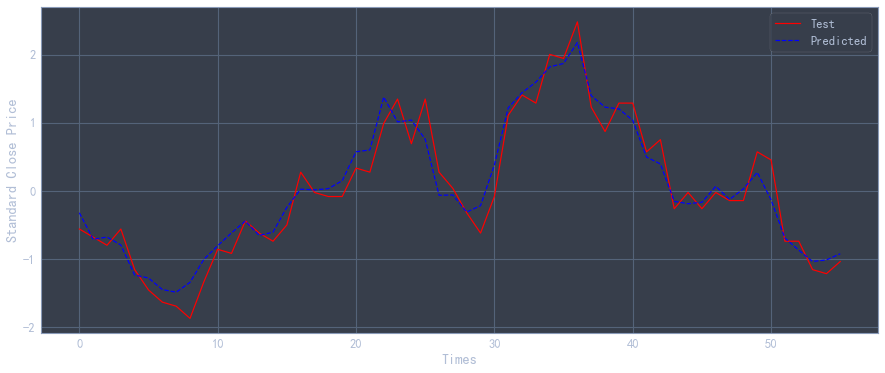

In [42]:
y_pred_GRU = model.predict(X_test)

plt.figure(figsize=(15, 6))
plt.plot(range(0, y_pred_GRU.shape[0]), y_test, color='red', label='Test')
plt.plot(range(0, y_pred_GRU.shape[0]),
         y_pred_GRU,
         color='blue',
         label='Predicted',
         linestyle='--')
plt.xlabel('Times')
plt.ylabel('Standard Close Price')
plt.legend()
plt.show()

# 尝试3

In [43]:
# 构建网络
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(None, X_train.shape[-1])))
model.add(Dense(1))

# 编译模型
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

cost = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
450/450 [==============================] - 0s 798us/step - loss: 0.8798 - mae: 0.7154
Epoch 2/200
450/450 [==============================] - 0s 69us/step - loss: 0.6134 - mae: 0.5980
Epoch 3/200
450/450 [==============================] - 0s 70us/step - loss: 0.3923 - mae: 0.4823
Epoch 4/200
450/450 [==============================] - 0s 69us/step - loss: 0.2038 - mae: 0.3517
Epoch 5/200
450/450 [==============================] - 0s 104us/step - loss: 0.0885 - mae: 0.2339
Epoch 6/200
450/450 [==============================] - 0s 69us/step - loss: 0.0329 - mae: 0.1395
Epoch 7/200
450/450 [==============================] - 0s 104us/step - loss: 0.0180 - mae: 0.1014
Epoch 8/200
450/450 [==============================] - 0s 69us/step - loss: 0.0132 - mae: 0.0864
Epoch 9/200
450/450 [==============================] - 0s 104us/step - loss: 0.0104 - mae: 0.0765
Epoch 10/200
450/450 [==============================] - 0s 69us/step - loss: 0.0083 - mae: 0.0689
Epoch 11/200
450/450 [===

450/450 [==============================] - 0s 69us/step - loss: 0.0011 - mae: 0.0245
Epoch 168/200
450/450 [==============================] - 0s 69us/step - loss: 0.0012 - mae: 0.0254
Epoch 169/200
450/450 [==============================] - 0s 69us/step - loss: 0.0014 - mae: 0.0260
Epoch 170/200
450/450 [==============================] - 0s 69us/step - loss: 0.0011 - mae: 0.0239
Epoch 171/200
450/450 [==============================] - 0s 69us/step - loss: 0.0012 - mae: 0.0254
Epoch 172/200
450/450 [==============================] - 0s 69us/step - loss: 0.0012 - mae: 0.0253
Epoch 173/200
450/450 [==============================] - 0s 69us/step - loss: 0.0012 - mae: 0.0254
Epoch 174/200
450/450 [==============================] - 0s 69us/step - loss: 0.0011 - mae: 0.0246
Epoch 175/200
450/450 [==============================] - 0s 69us/step - loss: 0.0011 - mae: 0.0245
Epoch 176/200
450/450 [==============================] - 0s 69us/step - loss: 0.0013 - mae: 0.0270
Epoch 177/200
450/450 [=

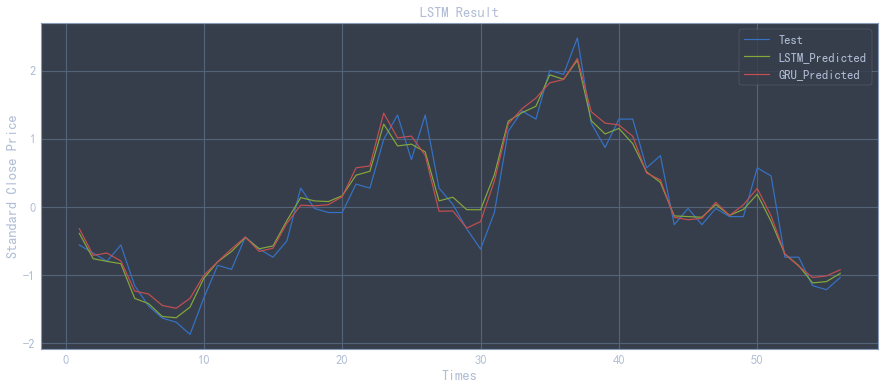

In [44]:
y_pred_LSTM = model.predict(X_test)
y_pred_LSTM_true = np.around(y_pred_LSTM * y_test_std + y_test_mean, 2)

plt.figure(figsize=(15, 6))
plt.plot(range(1, y_test.shape[0] + 1), y_test, label='Test')
plt.plot(range(1, y_pred_LSTM.shape[0] + 1),
         y_pred_LSTM,
         label='LSTM_Predicted')
plt.plot(range(1, y_pred_GRU.shape[0] + 1), y_pred_GRU, label='GRU_Predicted')
plt.xlabel('Times')
plt.ylabel('Standard Close Price')
plt.title('LSTM Result')
plt.legend()
plt.show()

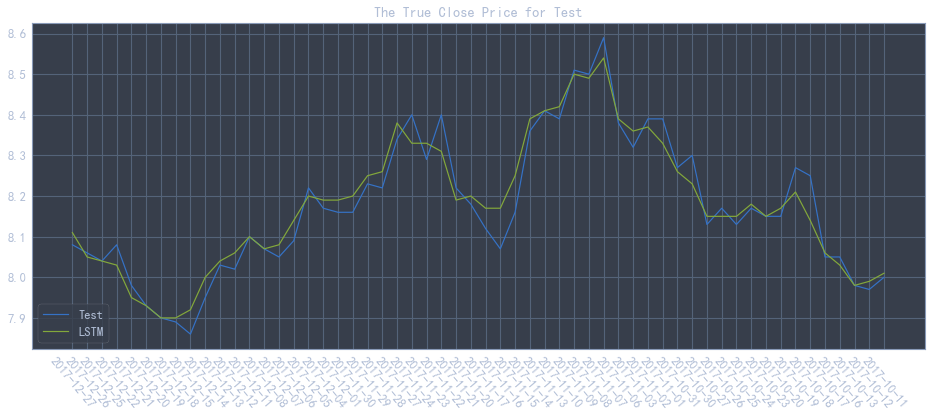

In [52]:
plt.figure(figsize=(16, 6))
plt.plot(y_data[num:], label='Test')
plt.plot(y_pred_LSTM_true, label='LSTM')
plt.title('The True Close Price for Test')
plt.legend(loc='lower left', prop={'style': 'italic'})
# 解决ticklabel字重叠：
plt.xticks(rotation=-50)
plt.show()

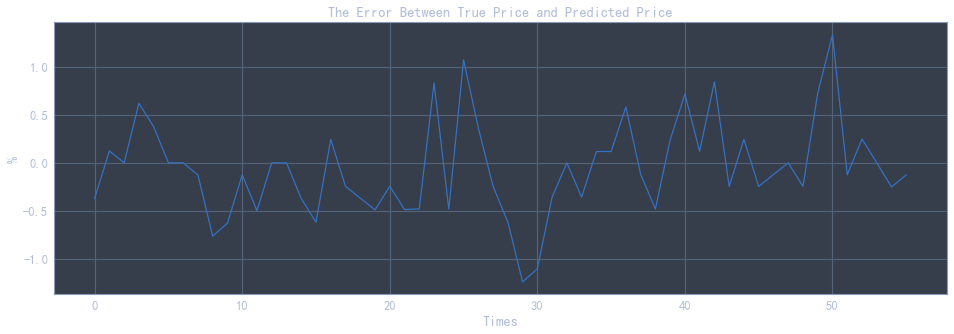

预测值平均误差: 0.05818861785130971 %


In [83]:
mean_error = (np.array(y_data[num:]).ravel() -
              y_pred_LSTM_true.ravel()) / np.array(y_data[num:]).ravel()
plt.figure(figsize=(16, 5))
plt.plot(mean_error * 100)
plt.xlabel('Times')
plt.title('The Error Between True Price and Predicted Price')
plt.ylabel('%')
plt.show()
print('预测值平均误差:', np.abs(np.mean(mean_error) * 100), "%")

# 尝试4

In [11]:
num = 450
y_data = data['close']
X_data = data.drop(['close'], axis=1)

X_train = scale(X_data[:num])
X_test = scale(X_data[num:])
y_train = scale(y_data[:num])
y_test = scale(y_data[num:])

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [13]:
model = Sequential()
model.add(
    Conv1D(32, 1, activation='relu', input_shape=(None, X_train.shape[-1])))
model.add(MaxPooling1D(1))
model.add(Conv1D(32, 1, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.compile(optimizer="rmsprop", loss='mse', metrics=['mae'])
cost = model.fit(X_train,
                 y_train,
                 epochs=300,
                 batch_size=5,
                 validation_split=0.2)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 360 samples, validate on 90 samples
Epoch 1/300
360/360 [==============================] - 1s 2ms/step - loss: 0.0890 - mean_absolute_error: 0.1921 - val_loss: 0.0655 - val_mean_absolute_error: 0.1515
Epoch 2/300
360/360 [==============================] - 0s 260us/step - loss: 0.0122 - mean_absolute_error: 0.0854 - val_loss: 0.0484 - val_mean_absolute_error: 0.1323
Epoch 3/300
360/360 [==============================] - 0s 260us/step - loss: 0.0081 - mean_absolute_error: 0.0672 - val_loss: 0.0641 - val_mean_absolute_error: 0.1561
Epoch 4/300
360/360 [==============================] - 0s 260us/step - loss: 0.0057 - mean_absolute_error: 0.0576 - val_loss: 0.0225 - val_mean_absolute_error: 0.0938
Epoch 5/300
360/360 [==============================] - 0s 260us/step - loss: 0.0051 - mean_absolute_error: 0.0548 - val_loss: 0.0256 - val_mean_absolute_error: 0.0974
Epoch 6/300
360/360 [=======================

Epoch 96/300
360/360 [==============================] - 0s 260us/step - loss: 0.0014 - mean_absolute_error: 0.0287 - val_loss: 0.0077 - val_mean_absolute_error: 0.0645
Epoch 97/300
360/360 [==============================] - 0s 217us/step - loss: 0.0018 - mean_absolute_error: 0.0308 - val_loss: 0.0086 - val_mean_absolute_error: 0.0669
Epoch 98/300
360/360 [==============================] - 0s 217us/step - loss: 0.0013 - mean_absolute_error: 0.0268 - val_loss: 0.0094 - val_mean_absolute_error: 0.0731
Epoch 99/300
360/360 [==============================] - 0s 217us/step - loss: 0.0015 - mean_absolute_error: 0.0283 - val_loss: 0.0083 - val_mean_absolute_error: 0.0657
Epoch 100/300
360/360 [==============================] - 0s 260us/step - loss: 0.0014 - mean_absolute_error: 0.0285 - val_loss: 0.0097 - val_mean_absolute_error: 0.0702
Epoch 101/300
360/360 [==============================] - 0s 217us/step - loss: 0.0013 - mean_absolute_error: 0.0279 - val_loss: 0.0104 - val_mean_absolute_erro

360/360 [==============================] - 0s 347us/step - loss: 0.0011 - mean_absolute_error: 0.0239 - val_loss: 0.0148 - val_mean_absolute_error: 0.0811
Epoch 193/300
360/360 [==============================] - 0s 217us/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0121 - val_mean_absolute_error: 0.0752
Epoch 194/300
360/360 [==============================] - 0s 217us/step - loss: 0.0010 - mean_absolute_error: 0.0230 - val_loss: 0.0120 - val_mean_absolute_error: 0.0748
Epoch 195/300
360/360 [==============================] - 0s 217us/step - loss: 9.8795e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0130 - val_mean_absolute_error: 0.0781
Epoch 196/300
360/360 [==============================] - 0s 217us/step - loss: 0.0010 - mean_absolute_error: 0.0241 - val_loss: 0.0116 - val_mean_absolute_error: 0.0721
Epoch 197/300
360/360 [==============================] - 0s 217us/step - loss: 9.7968e-04 - mean_absolute_error: 0.0231 - val_loss: 0.0137 - val_mean_absolute_error:

360/360 [==============================] - 0s 174us/step - loss: 7.7816e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0161 - val_mean_absolute_error: 0.0828
Epoch 241/300
360/360 [==============================] - 0s 217us/step - loss: 0.0010 - mean_absolute_error: 0.0237 - val_loss: 0.0149 - val_mean_absolute_error: 0.0813
Epoch 242/300
360/360 [==============================] - 0s 217us/step - loss: 9.2108e-04 - mean_absolute_error: 0.0218 - val_loss: 0.0294 - val_mean_absolute_error: 0.1154
Epoch 243/300
360/360 [==============================] - 0s 260us/step - loss: 9.7059e-04 - mean_absolute_error: 0.0233 - val_loss: 0.0131 - val_mean_absolute_error: 0.0774
Epoch 244/300
360/360 [==============================] - 0s 391us/step - loss: 8.4809e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0162 - val_mean_absolute_error: 0.0837
Epoch 245/300
360/360 [==============================] - 0s 434us/step - loss: 9.4852e-04 - mean_absolute_error: 0.0218 - val_loss: 0.0140 - val_mean_abs

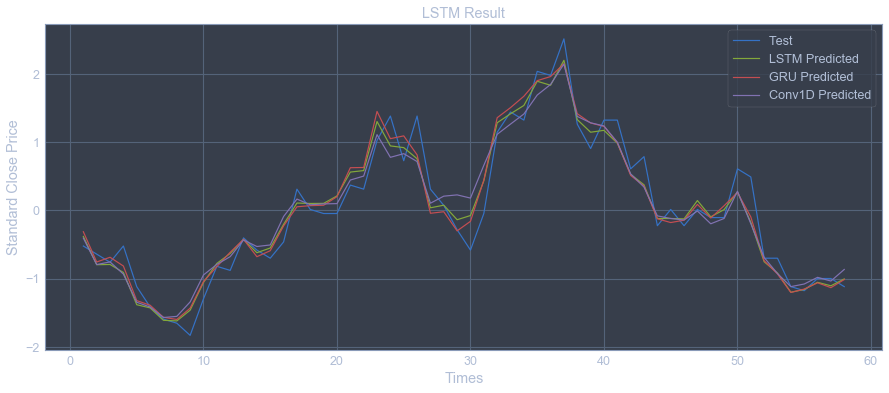

In [15]:
y_pred_Conv1D = model.predict(X_test)

model_GRU = load_model('E:/Jupyter/Results/Model/Quant_exercise_GRU_1.h5')
model_LSTM = load_model('E:/Jupyter/Results/Model/Quant_exercise_LSTM_1.h5')
y_pred_GRU = model_GRU.predict(X_test)
y_pred_LSTM = model_LSTM.predict(X_test)

plt.figure(figsize=(15, 6))
plt.plot(range(1, y_test.shape[0] + 1), y_test, label='Test')
plt.plot(range(1, y_pred_LSTM.shape[0] + 1),
         y_pred_LSTM,
         label='LSTM Predicted')
plt.plot(range(1, y_pred_GRU.shape[0] + 1), y_pred_GRU, label='GRU Predicted')
plt.plot(range(1, y_pred_Conv1D.shape[0] + 1),
         y_pred_Conv1D,
         label='Conv1D Predicted')
plt.xlabel('Times')
plt.ylabel('Standard Close Price')
plt.title('LSTM Result')
plt.legend()
plt.show()

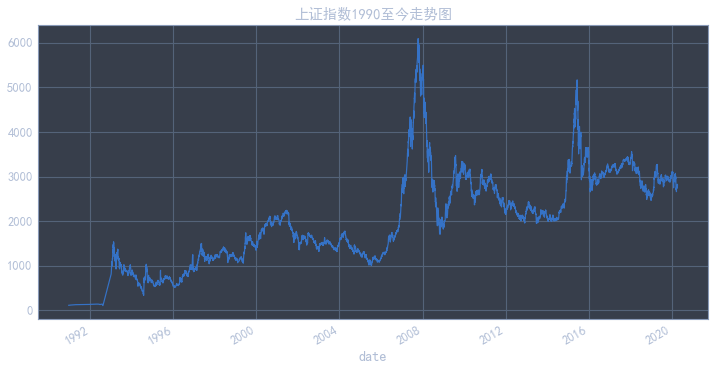

In [6]:
sh.index = pd.to_datetime(sh.date)
sh['close'].plot(figsize=(12, 6))
plt.title('上证指数1990至今走势图')
plt.xlabel('date')
plt.show()

In [7]:
sh.describe().round(2)

,open,close,high,low,volume
count,6991.00,6991.00,6991.00,6991.00,6.991000e+03
mean,1983.15,1984.46,2001.74,1963.27,7.790260e+07
std,1071.71,1073.09,1082.58,1059.60,1.071662e+08
min,105.50,105.50,105.50,105.50,1.000000e+01
25%,1196.14,1195.08,1206.72,1182.93,5.428534e+06
50%,1915.50,1914.09,1932.32,1895.18,2.844060e+07
75%,2838.25,2841.22,2868.00,2807.81,1.216340e+08
max,6057.43,6092.06,6124.04,6040.71,8.571328e+08


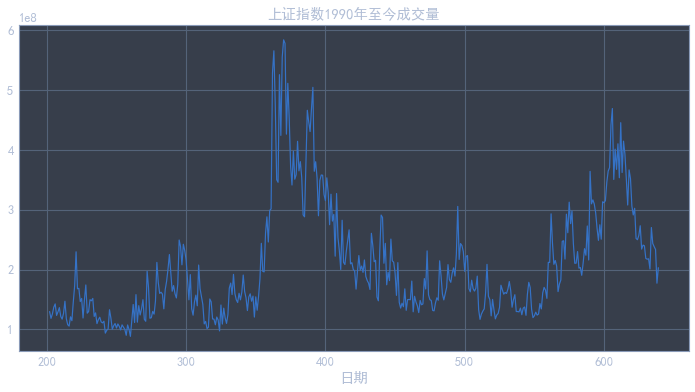

In [4]:
sh.loc["2019-01-01":]['volume'].plot(figsize=(12, 6))
plt.title('上证指数1990年至今成交量')
plt.xlabel('日期')
plt.show()

均线分析

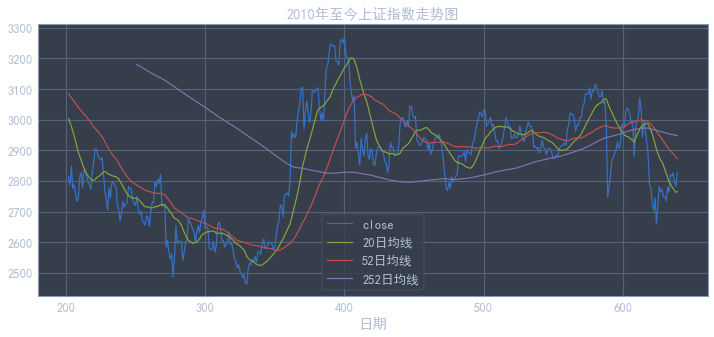

In [5]:
ma_day = [20, 52, 252]  # 手动设置20，52，252均线
for ma in ma_day:
    column_name = "%s日均线" % (str(ma))
    sh[column_name] = sh['close'].rolling(ma).mean()
#作出2010年至今的收盘、均线
sh.loc["2010-4-10":][['close', '20日均线', '52日均线',
                      '252日均线']].plot(figsize=(12, 5))
plt.title('2010年至今上证指数走势图')
plt.xlabel('日期')
plt.legend(['close', '20日均线', '52日均线', '252日均线'])
plt.show()

日收益率可视化

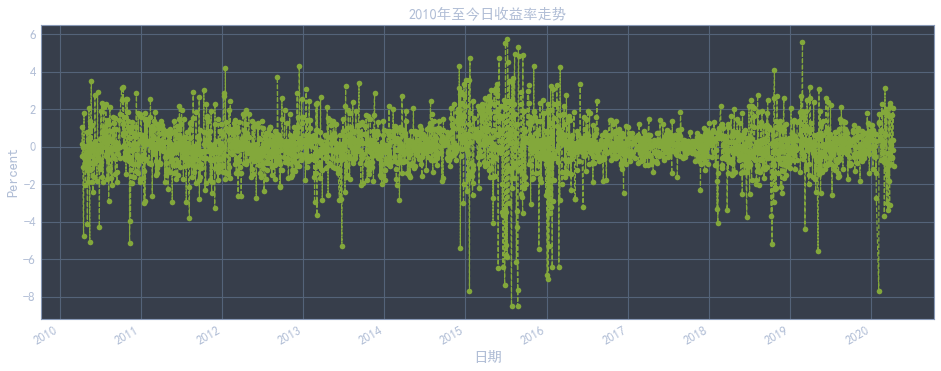

In [10]:
# 2010年至今日收益率走势
sh['日收益率'] = sh['close'].pct_change()
day_up = 100 * sh.loc['2010-4-10':]['日收益率']
day_up.plot(figsize=(16, 6), linestyle="--", marker='o', color='g')
plt.title('2010年至今日收益率走势')
plt.xlabel('日期')
plt.ylabel('Percent')
plt.show()

In [11]:
stocks = {
    '上证指数': 'sh',
    '深圳指数': 'sz',
    "沪深300": "hs300",
    '上证50': 'sz50',
    '中小指板': 'zxb',
    '创业版': 'cyb'
}
stock_index = pd.DataFrame()
for stock in stocks.values():
    stock_index[stock] = ts.get_k_data(stock,
                                       ktype='D',
                                       autype='qfq',
                                       start='2005-01-01')['close']
stock_index.head()

,sh,sz,hs300,sz50,zxb,cyb
0,1242.77,3025.42,1003.45,827.07,5788.976,997.119
1,1251.94,3052.86,995.42,831.43,5814.922,998.394
2,1239.43,3028.73,978.70,822.50,5666.934,1027.681
3,1244.75,3035.59,1000.90,823.62,5718.764,1069.468
4,1252.40,3062.73,986.97,832.99,5462.570,1067.154


In [24]:
tech_rets = stock_index.pct_change()[1:]  # 每日跌涨幅
tech_rets.describe()

,sh,sz,hs300,sz50,zxb,cyb
count,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000
mean,0.000353,0.000507,0.000506,0.000475,0.000190,0.000316
std,0.016168,0.018540,0.017134,0.017323,0.016961,0.015991
min,-0.088407,-0.092898,-0.092400,-0.094705,-0.086207,-0.089097
25%,-0.006568,-0.008291,-0.006965,-0.007316,-0.006235,-0.003692
50%,0.000756,0.000648,0.000663,0.000322,0.000000,0.000000
75%,0.008069,0.010123,0.008606,0.008603,0.008068,0.005146
max,0.094549,0.095942,0.093418,0.096731,0.097128,0.071586


In [26]:
tech_rets.mean()*100

sh       0.035285
sz       0.050729
hs300    0.050604
sz50     0.047461
zxb      0.019017
cyb      0.031584
dtype: float64

In [6]:
sns.jointplot('sh', 'sz', data=tech_rets)

NameError: name 'tech_rets' is not defined

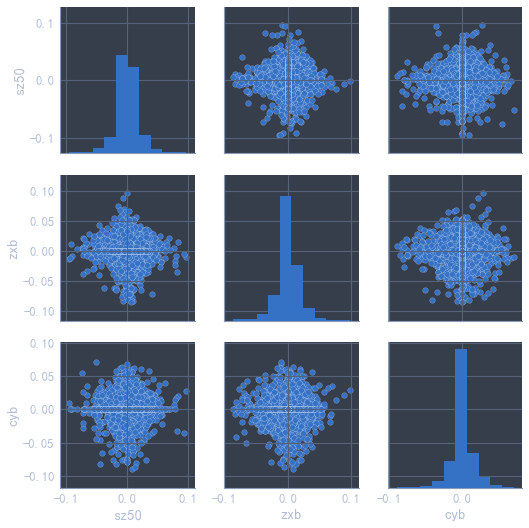

In [29]:
sns.pairplot(tech_rets.iloc[:, 3:].dropna())

C:\Python\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Python\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\Python\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


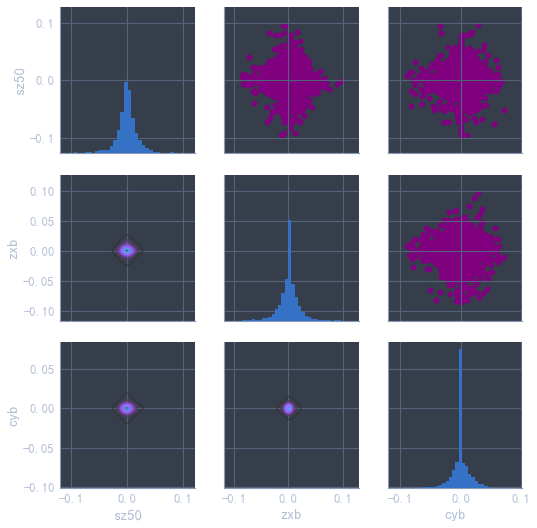

In [35]:
returns_fig = sns.PairGrid(tech_rets.iloc[:, 3:])
returns_fig.map_upper(plt.scatter, color='purple')  # 右上角散点图
returns_fig.map_lower(sns.kdeplot, cmap="cool_d")  # 左下角核密度图
returns_fig.map_diag(plt.hist, bins=30)  # 对角线直方图

In [51]:
def get_risk(stocks, startdate='2010-4-10'):  # 收益率与标准差函数
    close = pd.DataFrame()
    for stock in stocks.values():
        close[stock] = ts.get_k_data(stock,
                                     ktype='D',
                                     autype='qfq',
                                     start=startdate)['close']

    tech_rets = close.pct_change()[1:]  # 每日跌涨幅
    rets = tech_rets.dropna()
    ret_mean = rets.mean() * 100
    ret_std = rets.std() * 100
    return ret_mean, ret_std

In [67]:
def plot_risk(stocks, startdate='2019-01-01'):
    ret, vol = get_risk(stocks, startdate)
    color = np.array([0.18, 0.96, 0.75, 0.3, 0.9, 0.5])
    plt.scatter(ret,
                vol,
                marker='o',
                c=color,
                s=500,
                cmap=plt.get_cmap('Spectral'))
    plt.xlabel('日均收益率 %')
    plt.ylabel('标准差 %')

    for label, x, y in zip(stocks.keys(), ret, vol):
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(20, 20),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     bbox=dict(boxstyle='round,pad=0.5',
                               fc='yellow',
                               alpha=0.5),
                     arrowprops=dict(arrowstyle="->",
                                     connectionstyle="arc3,rad=0"))

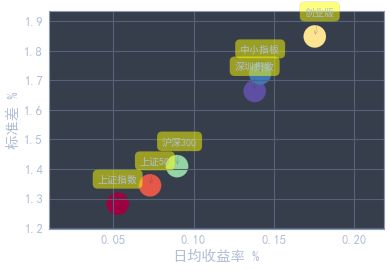

In [68]:
stocks = {
    '上证指数': 'sh',
    '深圳指数': 'sz',
    "沪深300": "hs300",
    '上证50': 'sz50',
    '中小指板': 'zxb',
    '创业版': 'cyb'
}

plot_risk(stocks=stocks)

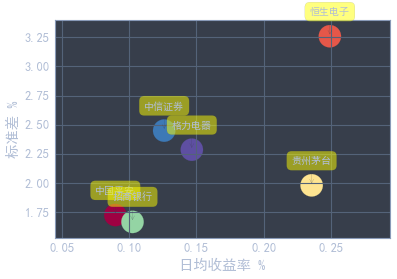

In [61]:
stocks = {
    '中国平安': '601318',
    '格力电器': '000651',
    '招商银行': '600036',
    "恒生电子": '600570',
    "中信证券": "600030",
    "贵州茅台": '600519'
}
starttime = '2019-01-01'
plot_risk(stocks=stocks, startdate=starttime)

# 尝试5

In [34]:
df = ts.get_hist_data('sh', start='2017-06-15')
data = df
num = 500
y_data = data['close']
X_data = data.drop(['close'], axis=1)

X_train = pd.DataFrame(scale(X_data[:num]))
X_test = pd.DataFrame(scale(X_data[num:]))
y_train = scale(y_data[:num])
y_test = scale(y_data[num:])

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=1000,
                                   max_depth=10,
                                   random_state=7)
rfc_model.fit(X_train.values, y_train.astype('int'))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

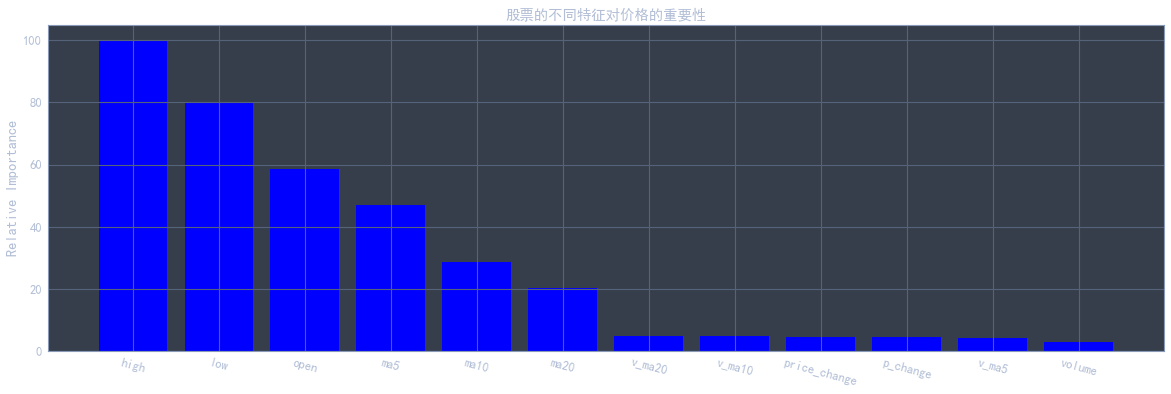

In [37]:
import sys
sys.path.append('E:/Jupyter/JupyterProjects/Machine_Learning_Exercise/')
from draw_in_ml import plot_feature_importances as pfi
pfi(rfc_model.feature_importances_,
    feature_names=X_data.columns,
    color='blue',
    title='股票的不同特征对价格的重要性')

# 尝试6

In [54]:
from sklearn.cluster import SpectralClustering, AffinityPropagation, Birch, DBSCAN, KMeans
import sklearn.metrics as ms

data = ts.get_stock_basics()
data = data.iloc[:, 3:]

K_means = KMeans(n_clusters=8)
K_means.fit(data)
KMeans_score = ms.silhouette_score(data,
                                   K_means.labels_,
                                   metric='euclidean',
                                   sample_size=len(data))
KMeans_ch_score = ms.calinski_harabaz_score(data, K_means.labels_)
print('KMeans聚类轮廓系数得分：', KMeans_score)
print('KMeans聚类不同组间距得分：', KMeans_ch_score)

spectral_cluster = SpectralClustering(n_clusters=8)
spectral_cluster.fit(data)
spectral_score = ms.silhouette_score(data,
                                     spectral_cluster.labels_,
                                     metric='euclidean',
                                     sample_size=len(data))
spectral_ch_score = ms.calinski_harabaz_score(data, spectral_cluster.labels_)
print('谱聚类轮廓系数得分：', spectral_score)
print('谱聚类不同组间距得分：', spectral_ch_score)

birch_cluster = Birch()
birch_cluster.fit(data)
birch_score = ms.silhouette_score(data,
                                  birch_cluster.labels_,
                                  metric='euclidean',
                                  sample_size=len(data))
birch_ch_score = ms.calinski_harabaz_score(data, birch_cluster.labels_)
print('Birch方法轮廓系数得分：', birch_score)
print('Birch方法不同组间距得分', birch_ch_score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


KMeans聚类轮廓系数得分： 0.5189634161679733
KMeans聚类不同组间距得分： 846103.3070393997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


谱聚类轮廓系数得分： 0.9790792263584117
谱聚类不同组间距得分： 200.06649759960374
Birch方法轮廓系数得分： 0.5688934928449322
Birch方法不同组间距得分 682500.738845173


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
